# Include libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# set pandas preferences for output

In [66]:
# Set interactive output options
# to see all of the output
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# press 'o' to hyde cell output

# Get data

In [2]:
parent_dir = "./data/"

application = pd.read_csv(parent_dir + 'application_train.csv')
# bureau = pd.read_csv(parent_dir + 'bureau.csv')
# credit_card_balance = pd.read_csv(parent_dir + 'credit_card_balance.csv')

/var/folders/sv/tvszn8qx11ngcrsl6yd8t3c80000gp/T/ipykernel_65407/3483327915.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  application = pd.read_csv(parent_dir + 'application_train.csv')


In [3]:
target_col = 'TARGET'

application.shape

(307511, 122)

# Show info

In [ ]:
print("Application Train Summary:\n", application.info())
# print("Bureau Summary:\n", bureau.info())
# print("Credit Card Balance Summary:\n", credit_card_balance.info())
application.summary()

0.08781828601345662


<Figure size 600x400 with 0 Axes>

<Axes: xlabel='TARGET'>

Text(0.5, 1.0, 'Target Distribution')

Text(0.5, 0, 'Default (1) or Not (0)')

Text(0, 0.5, 'Count')

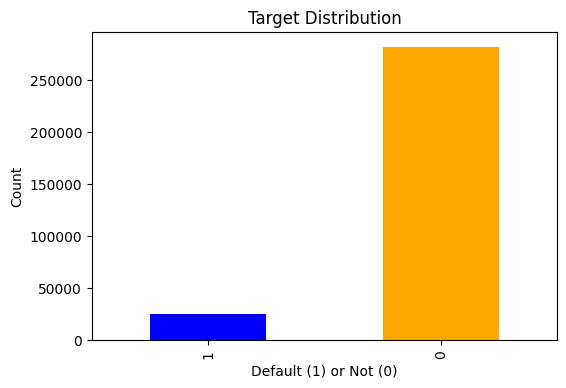

In [68]:
target_dist = application['TARGET'].value_counts(ascending=True)
target_probability = print(target_dist[1] / target_dist[0])
plt.figure(figsize=(6, 4))
target_dist.plot(kind='bar', color=['blue', 'orange'])
plt.title('Target Distribution')
plt.xlabel('Default (1) or Not (0)')
plt.ylabel('Count')
plt.show()

In [ ]:
missing_values = application.isnull().sum().sort_values(ascending=False)
print(len(application))
print("Missing Values in Application:\n", missing_values[missing_values > 0])


In [ ]:
numeric_columns = application.select_dtypes(include=['float64', 'int64'])
# correlations = numeric_columns.corr()['TARGET'].sort_values()
# print("Correlation with TARGET:\n", correlations.tail(10))
print(numeric_columns.columns.size)
print(numeric_columns)

In [ ]:
# get list of categorial features
cols = application.columns
continuous_features = []
for column in cols:
    if application[column].nunique() > 100:
        continuous_features.append(column)

print(continuous_features)
print(len(continuous_features))
# get list of numeric features
# floatFeatures = application.select_dtypes(include='float64').columns

# integerFeatures = application.select_dtypes(include='int64').columns

# for column in integerFeatures:
#     if column in nonFloatTypes: # categorial
#         integerFeatures = integerFeatures.delete(integerFeatures.get_loc(column))
# print(integerFeatures)

## Построение бокс - графиков для проверки выбросов

In [8]:
def BoxPlotColumns(data, columns):
# Создание подграфиков
	num_features = len(columns)
	num_cols = int(np.ceil(np.sqrt(num_features)))

	# num_cols = 10  # Количество колонок в сетке
	num_rows = int(np.ceil(num_features / num_cols))  # Количество строк

	# Создание подграфиков
	fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 4 * num_rows))
	# fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(5 * num_features, 4))

	# Построение boxplot для каждой колонки
	index = 0
	for ax_arr in axes:
		for ax, column in zip(ax_arr, columns[index: index + num_rows]):
			g = sns.boxplot(y=data[column], ax=ax)
			# var = g.set_xticklabels(g.get_xticklabels(), rotation=90)
			ax.set_title(f'Boxplot for {column}')
			ax.set_ylabel(column)
		index = index + num_rows

	# Показать графики
	plt.tight_layout()
	plt.show()
 
 
def plot_histograms(application, columns):
    # Выбор числовых данных
    
    # Количество признаков
    num_features = len(columns)
    num_cols = int(np.ceil(np.sqrt(num_features)))  # Количество колонок в сетке
    num_rows = int(np.ceil(num_features / num_cols))  # Количество строк
    # Создание подграфиков
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 4 * num_rows))
    # Построение гистограммы для каждой колонки
    index = 0
    for ax_arr in axes:
        for ax, column in zip(ax_arr, columns[index: index + num_rows]):
            # Построение гистограммы
            sns.histplot(application[column], ax=ax, bins=20, kde=True, color='blue', alpha=0.7)
            ax.set_title(f'Histogram for {column}')
            ax.set_xlabel(column)
            ax.set_ylabel('Frequency')
        index = index + num_rows
    # Удаление пустых подграфиков, если они есть
    for j in range(index, num_rows * num_cols):
        fig.delaxes(axes.flatten()[j])
    # Показать графики
    plt.tight_layout()
    plt.show()

BoxPlotColumns(application, continuous_features)

NameError: name 'continuous_features' is not defined

# Предобработка данных (удаление / заполнение пропусков, кодировка категориальных признаков)

In [9]:
## удаляем признаки с числом пропущенных значений больше 50%
threshold = 0.5
missing_ratio = application.isnull().sum() / len(application)
columns_to_drop = missing_ratio[missing_ratio > threshold].index
application = application.drop(columns=columns_to_drop, axis=1)
print(columns_to_drop)

Index(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE'],
      dtype='object')


In [10]:
# разделяем столбцы на числовые и нечисловые данные
numeric_data = application.select_dtypes(include=['float64', 'int64'])
non_numeric_data = application.select_dtypes(exclude=['float64', 'int64'])

In [11]:
# для числовых данных заменяем пропущенные значения на медиану столбца
imputer_numeric = SimpleImputer(strategy='median')
numeric_data_imputed = pd.DataFrame(imputer_numeric.fit_transform(numeric_data), columns=numeric_data.columns)

# заменяет пропущенные значения в нечисловых столбцах на наиболее часто встречаемое
imputer_non_numeric = SimpleImputer(strategy='most_frequent')
non_numeric_data_imputed = pd.DataFrame(imputer_non_numeric.fit_transform(non_numeric_data), columns=non_numeric_data.columns)

application_imputed = pd.concat([numeric_data_imputed, non_numeric_data_imputed], axis=1)


In [ ]:
# BoxPlotColumns(numeric_data_imputed, numeric_data.columns)
# plot_histograms(numeric_data_imputed, numeric_data.columns)

In [12]:
# для каждого категориального признака сопоставляет колонки
# feature_main (values in column) = feature1 (value 1[0, 1]) feature2 (value 2[0 ,1]) ...
# может возникнуть проблема с потерей информации при кодировании, смотреть отдельно для каждого признака
# использовать для таких признаков более точные кодировки (типа бинари)
categorical_columns = application_imputed.select_dtypes(include=['object']).columns
application_imputed = pd.get_dummies(application_imputed, columns=categorical_columns, drop_first=True)

after_merge_imputer = SimpleImputer(strategy='median')
application_final = pd.DataFrame(
    after_merge_imputer.fit_transform(application_imputed),
    columns=application_imputed.columns
)

In [ ]:
from diplom_project.models.logistic_reg import *
logistic_regression_fit_predict(application_final, 'TARGET', 0.2, threshold=0.2)

In [ ]:
from diplom_project.transformers.numeric import handle_outliers, fill_numeric_missing
from diplom_project.transformers.categorial import one_hot_encode_columns, impute_with_mode

application_final, _ = handle_outliers(application_final, columns=numeric_data.drop(columns='TARGET').columns, method='iqr', strategy='transform')

In [ ]:
def calculate_outliers_variance(data: pd.Series, threshold):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr_range = q3 - q1
    lower_bound = q1 - threshold * iqr_range
    upper_bound = q3 + threshold * iqr_range
    outliers_mask = (data < lower_bound) | (data > upper_bound)
    new_series = data[outliers_mask].copy()
    return new_series.var()

In [ ]:
from matplotlib import pyplot as plt

data = application_final["EXT_SOURCE_3"]

q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
iqr_range = q3 - q1
lower_bound = q1 - threshold * iqr_range
upper_bound = q3 + threshold * iqr_range
outliers_mask = (data < lower_bound) | (data > upper_bound)
new_series = data[outliers_mask].copy()

plt.plot(data=new_series)

# Некоторые методы фильтрации данных

## Pearson Kendall spearman corrs

### pearson

In [ ]:
# коэффицент пирсона следует использовать на непрерывных данных

correlation_ps = application_final.corr(method = 'pearson') # method = pearson or spearman or kendall
# print(correlation[target_col].abs().sort_values(ascending=False))



In [ ]:
corr_tg_abs_ps =  correlation_ps[target_col].abs()

print("Mean correlation: ",corr_tg_abs_ps.mean())
print("quantile 0.25: ",corr_tg_abs_ps.quantile(0.25))
print("quantile 0.4: ",corr_tg_abs_ps.quantile(0.4))
print("quantile 0.5: ",corr_tg_abs_ps.quantile(0.5))
print("quantile 0.6: ",corr_tg_abs_ps.quantile(0.6))
print("quantile 0.75: ",corr_tg_abs_ps.quantile(0.75))

corr_tg_abs_ps.sort_values(ascending=False).head(11)



In [ ]:
corr_tg_abs_ps.sort_values(ascending=False)

### t-student linear regression model

In [ ]:
import scipy.stats as st 
# проверка на отбранных колонках

# return index of result series
def get_columns_percentile(data: pd.Series, percentile :float):
    s = data.ge(data.quantile(percentile))
    # boolean indexing
    return s[s].index

# calculates t-value for given features and returns list with elems 
def get_important_features(data: pd.Series, alpha = 0.05):
    n = data.size
    df = n - 2
    critical_value = st.t.ppf(1 - alpha, df)
    t = [abs(r) * np.sqrt(n - 2)*np.sqrt(1 - r*r) for r in data]
    new_series = pd.Series(t, index = data.index)
    # print("critical_value: ", critical_value)
    return new_series.ge(critical_value)
    # return new_series
    

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import root_mean_squared_error

def custom_predict(X, threshold, model):
    probs = model.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)

def LinearByStudentImportancy(df, corr = corr_tg_abs_ps, alpha = 0.05, penalty='l2'):
    """penalty: Literal['l1', 'l2', 'elasticnet'] | None = "l2","""
    
    imp_f = get_important_features(corr, alpha=alpha)
    
    
    columns = [i for i in df.columns if i in imp_f[imp_f]]
    # print (columns)
    
    X = df[columns]
    y = df['TARGET']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	# стандартизирует диапазон входных данных
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(penalty = penalty)
    model.fit(X_train_scaled, y_train)
    
    # predictions = model.predict(X_test_scaled)
    predictions = custom_predict(X_test_scaled, 0.18, model=model)
    # print(predictions)
	# predictions = model.score(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[: ,1]
    auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[: ,1])
    print("features selected: {0}, alpha: {1}".format(len(columns), alpha))
    print("Метрики качества модели:")
    print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
    print(f"Precision: {precision_score(y_test, predictions):.4f}")
    print(f"Recall: {recall_score(y_test, predictions):.4f}")
    print(f"F1-score: {f1_score(y_test, predictions):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"rmse: {root_mean_squared_error(y_test, y_proba):.4f}")
    print("\nМатрица ошибок:")
    print("tn    fn\ntp     fp:")
    print(confusion_matrix(y_test, predictions))    
    print("AUC Score:", auc)
    


In [ ]:
corr_tg_abs_ps =  correlation_ps[target_col]
# print(corr_tg_abs_ps)

LinearByStudentImportancy(corr = corr_tg_abs_ps, alpha=0.05)
LinearByStudentImportancy(corr = corr_tg_abs_ps, alpha=0.1)
LinearByStudentImportancy(corr = corr_tg_abs_ps, alpha=0.2)
LinearByStudentImportancy(corr = corr_tg_abs_ps, alpha=0.3)
LinearByStudentImportancy(corr = corr_tg_abs_ps, alpha=0.4)
LinearByStudentImportancy(corr = corr_tg_abs_ps, alpha=0.45)

### analize pearson correlation results

In [ ]:
imp_f = get_important_features(corr_tg_abs_ps, alpha = 0.45)
columns = [i for i in application_final.columns if i in imp_f[imp_f]]
print(columns)

In [ ]:
import scipy.stats as st

normal = 0

for col in columns:
    res = st.normaltest(application_final[col])
    alpha = 0.05
    print(res.pvalue, col, len(application_final[col].unique()))
    if res.pvalue > alpha:
        normal+=1
	
print("Нормально распределенных признаков: {0}".format(normal))

In [ ]:


# plot_histograms(application_final, columns)
# BoxPlotColumns(application_final, columns=columns)


### spearman

In [ ]:
correlation_sm = application_final.corr(method = 'spearman') # method = pearson or spearman or kendall
print(correlation_sm[target_col].abs().sort_values(ascending=False))

In [ ]:
corr_tg_abs_sm =  correlation_sm[target_col]
# corr_tg_abs = correlation.abs()
# corr_tg_abs_ps =  correlation_ps[target_col].abs().sort_values(ascending=False)

get_important_features(corr_tg_abs_sm, alpha=0.45)

LinearByStudentImportancy(corr = corr_tg_abs_sm, alpha=0.05)
LinearByStudentImportancy(corr = corr_tg_abs_sm, alpha=0.1)
LinearByStudentImportancy(corr = corr_tg_abs_sm, alpha=0.2)
LinearByStudentImportancy(corr = corr_tg_abs_sm, alpha=0.3)
LinearByStudentImportancy(corr = corr_tg_abs_sm, alpha=0.4)
LinearByStudentImportancy(corr = corr_tg_abs_sm, alpha=0.45)

In [ ]:
corr_tg_abs.sort_values(ascending=False)
# name_education_type
# количество признаков, точность
# 

### Сравнение Пирсона и Спирмена

In [ ]:
ft_sm = get_important_features(corr_tg_abs_sm, alpha=0.45)
ft_ps = get_important_features(corr_tg_abs_ps, alpha=0.3)

ft_sm = [i for i in application_final.columns if i in ft_sm[ft_sm]]
ft_ps = [i for i in application_final.columns if i in ft_ps[ft_ps]]


# list(ft_sm)
sm_ps = [feature for feature in ft_sm if feature not in ft_ps]
ps_sm = [feature for feature in ft_ps if feature not in ft_sm]
print(sm_ps)
print(ps_sm)
application_final[ps_sm].hist(figsize=(6, 6))

### linear all features

In [ ]:
X = application_final.drop(columns= ['SK_ID_CURR', 'TARGET'])
y = application_final['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	# стандартизирует диапазон входных данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, solver='newton-cg')
model.fit(X_train_scaled, y_train)
    
predictions = model.predict(X_test_scaled)
print(predictions)
	# predictions = model.score(X_test_scaled)
auc = roc_auc_score(y_test, predictions)
print("features selected: {0}".format(len(application_final.columns)))
print("AUC Score:", auc)

## mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_classif
# Предполагаем, что application_final, target_col и другие переменные уже определены
X = application_final.drop(columns=target_col)
y = application_final[target_col]
mi = mutual_info_classif(X, y, discrete_features=True)
# Создаем список кортежей (значение взаимной информации, имя колонки)
mi_names = list(zip(mi, application_final.columns))
# Сортируем список по значениям взаимной информации в порядке убывания
mi_names.sort(key=lambda x: x[0], reverse=True)
# Выводим отсортированный список
for score, name in mi_names:
    print(f'Column: {name}, MI: {score}')

### RFE жадный алгоритм

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

n_features_to_select = 1
application_final = (rd.data[rd.roles['Numeric'] + rd.roles['Categorial'] + ['TARGET']]).copy()

X = application_final.drop(columns=['TARGET'], errors='ignore')
y = application_final['TARGET']
# X = application_final
# y = rd.data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


regressor = LogisticRegression()

#===========================================================================
# perform a scikit-learn Recursive Feature Elimination (RFE)
#===========================================================================
from sklearn.feature_selection import RFE
# here we want only one final feature, we do this to produce a ranking
n_features_to_select = 1
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X_train_scaled, y_train)

from operator import itemgetter

features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)


In [ ]:
print(sorted(list(zip(rfe.ranking_, features)), key=itemgetter(0)))
rfe_features_sorted = [item[1] for item in sorted(list(zip(rfe.ranking_, features)), key=itemgetter(0))]
print(rfe_features_sorted)


In [ ]:
from sklearn.metrics import accuracy_score
def custom_predict(X, threshold):
    probs = model.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)

number_of_features = 89
X = application_final[rfe_features_sorted[:number_of_features]]
y = application_final['TARGET']
# y = rd.data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	# стандартизирует диапазон входных данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# стандартизирует диапазон входных данных
# cols_to_scale = []
# for col in rd.roles['Numeric']:
#     if col in rfe_features_sorted[:number_of_features]:
#         cols_to_scale.append(col)

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), cols_to_scale),
#         ('passthrough', 'passthrough', [col for col in X.columns if col not in cols_to_scale])
#     ])

# # Применяем трансформацию
# X_train_scaled = preprocessor.fit_transform(X_train)
# X_test_scaled = preprocessor.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
    
# threshold_sigmoid = 0.5
# lambda_sigmoid =  lambda x: 1 if x > 0.1 else 0
predictions = custom_predict(X=X_test_scaled, threshold=0.18)
vc = pd.Series(predictions).value_counts()
# print(vc[1] / vc[0])
# predictions_sigmoid = [lambda_sigmoid(x) for x in predictions]
# print([lambda_sigmoid(x) for x in predictions])
	# predictions = model.score(X_test_scaled)
# print(accuracy_score(y_test, predictions))
auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
print("features selected: {0}".format(len(X.columns)))
print("AUC Score:", auc)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
# TN, FP
# FN, TP
print(cm)
print((cm[1][1]) / (cm[1][1] + cm[1][0]))
print(len(y_test), len(predictions))



In [ ]:
model.predict(X=X_test_scaled)

In [ ]:
first_22_rfe = rfe_features_sorted[:22]
list_f = [feature for feature in first_22_rfe if feature not in ft_ps]
list_f
application_final[list_f].hist(figsize=(10,10))

# Random forest classifier

In [ ]:


X = application_final.drop(columns=['TARGET', 'SK_ID_CURR'])
y = application_final['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# стандартизирует диапазон входных данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=2, random_state=42, n_estimators=300)
model.fit(X_train_scaled, y_train)


predictions = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, predictions)
print("AUC Score:", auc)



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from random import randint
param_dist = {
    'max_depth': [2, 4, 8, 16],
    'min_samples_split': [2, 4, 8, 16],
    'min_samples_leaf': [2, 4, 8, 16],
    'n_estimators': [100, 200, 300 ,500]
}
dtree_reg = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(dtree_reg, param_distributions=param_dist, 
                                   n_iter=64, cv=5, random_state=42)
random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print(f"Best Parameters (Random Search): {best_params_random}")
print(f"Best Score (Random Search): {best_score_random}")

In [ ]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()



In [ ]:

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)



forest_importances = pd.Series(importances, index=X_train.columns.values)

# plot_data = forest_importances.sort_values(ascending=True).tail(15)

# fig, ax = plt.subplots()
# plot_data.plot.bar(ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout(
forest_importances.sort_values(ascending=False)


In [ ]:
features_n = 70

cols_fst = forest_importances[:features_n].index.values
cols_rfe = rfe_features_sorted[:features_n]
# print("fst: ",cols_fst)

# list(ft_sm)
fst_rfe = [feature for feature in cols_fst if feature not in cols_rfe]
# print("rfe: ",cols_rfe)
# rfe_fst = [feature for feature in ft_ps if feature not in ft_sm]
fst_rfe
print([feature1 for feature1, feature2 in zip(cols_fst, cols_rfe) if feature1 != feature2])
# # print(sm_ps)
# # print(ps_sm)
# application_final[fst_rfe].hist(figsize=(6, 6))
cols_fst

# Desicion tree classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
# columns_dt = application_final[rfe_features_sorted[:30]]
columns_dt = application_final.drop(columns=['TARGET', 'SK_ID_CURR']).columns
X = application_final[columns_dt]


y = application_final['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# стандартизирует диапазон входных данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = DecisionTreeClassifier(max_depth=7, min_samples_split=2, min_samples_leaf=2, random_state=42)
model.fit(X_train_scaled, y_train)


predictions = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, predictions)
print("AUC Score:", auc)
# plot_tree(decision_tree=model)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from random import randint
param_dist = {
    'max_depth': [2, 4, 8, 16],
    'min_samples_split': [2, 4, 8, 16],
    'min_samples_leaf': [2, 4, 8, 16]
}
dtree_reg = DecisionTreeClassifier(random_state=42)
random_search = RandomizedSearchCV(dtree_reg, param_distributions=param_dist, 
                                   n_iter=64, cv=5, random_state=42)
random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print(f"Best Parameters (Random Search): {best_params_random}")
print(f"Best Score (Random Search): {best_score_random}")

In [ ]:

feat_importances = pd.DataFrame(model.feature_importances_,  index=columns_dt, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
# feat_importances.plot(kind='bar', figsize=(8,6))
feat_importances[:89]

# new res


## read data

In [4]:
method = 'iqr'
if method == 'zscore':
    threshold = 3
if method == 'iqr':
    threshold = 1.5
strategy = 'transform'

outliers_percentage_threshold = 0.15
impute = True

In [ ]:
from diplom_project.reader.reader import Reader
from diplom_project.transformers.numeric import handle_outliers, fill_numeric_missing
from diplom_project.transformers.categorial import *
from scipy.stats import zscore, iqr
from diplom_project.reader.roles import DropRole

rd = Reader(application, target_col='TARGET', id_col='SK_ID_CURR', max_constant_rate=0.995, max_nan_rate=0.45)
print(f"features dropped: {len(rd._get_features_role(DropRole()))}")
print("dropped features: ",rd._get_features_role(DropRole()))
roles = rd.roles
# print(roles)

ModuleNotFoundError: No module named 'reader'

In [ ]:
print(f"features dropped: {len(rd._get_features_role(DropRole()))}")
print("dropped features: ",rd._get_features_role(DropRole()))

In [ ]:



# method can be zscore or iqr
def count_light_extremal_outliers_ratio(data: pd.DataFrame, col, method = 'zscore'):
    if method == 'zscore':
        z_scores = zscore(data[col])
        threshold_light = 3
        threshold_extreme = 3.5
        outliers_light_n = len(z_scores[(np.abs(z_scores) < threshold_extreme) & (np.abs(z_scores) > threshold_light)])
        outliers_extreme_n = len(z_scores[(np.abs(z_scores) > threshold_extreme)])
        if outliers_extreme_n == 0:
            ratio = 1.5
        else:
            ratio = outliers_light_n / outliers_extreme_n
    elif method == 'iqr':
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr_range = q3 - q1
        
        lower_bound_light = q1 - threshold * iqr_range
        upper_bound_light = q3 + 2* threshold * iqr_range
        
        lower_bound_extreme = q1 - threshold * iqr_range
        upper_bound_extreme = q3 + 2*threshold * iqr_range
        
        outliers_light_mask = data[col].mask(data[col] > lower_bound_extreme and data[col] < lower_bound_light) | (data[col] > upper_bound_light and data[col] < upper_bound_extreme)
        outliers_extreme_mask = data[col].mask((data[col] < lower_bound_extreme) | (data[col] > upper_bound_extreme))
        
        ratio = data[outliers_light_mask] / data[outliers_extreme_mask]
    return ratio

outliers_stat = {}


    
	
rd.data = impute_with_mode(df=rd.data, columns=roles['Numeric'], strategy='median')

rd.data = impute_with_mode(df=rd.data, columns=roles['Categorial'], strategy='most_frequent')
rd.guess_roles()
rd.data = one_hot_encode_columns(df=rd.data, columns_to_encode=roles['Categorial'])

res = {'transform': [], 'impute': [], 'clip': []}
for col in roles["Numeric"]:

    outliers_mask = np.zeros(len(rd.data), dtype=bool)
    
    if method == 'iqr':
        q1 = rd.data[col].quantile(0.25)
        q3 = rd.data[col].quantile(0.75)
        iqr_range = q3 - q1
        lower_bound = q1 - threshold * iqr_range
        upper_bound = q3 + threshold * iqr_range
        outliers_mask = (rd.data[col] < lower_bound) | (rd.data[col] > upper_bound)
    else:
        z_scores = zscore(rd.data[col])
        outliers_mask = np.abs(z_scores) > threshold
        
    # Считаем количество выбросов в колонке
    outliers_count = outliers_mask.sum()
    # print(f"{col}:  {outliers_count}")
	# Считаем общее количество значений в колонке
    total_count = len(rd.data)
	# Вычисляем процент выбросов
    outliers_percentage = float(outliers_count) / total_count
    outliers_stat[col] = outliers_percentage
    
    
    if outliers_percentage > outliers_percentage_threshold:
        strategy = 'transform'
    else:
        if impute:
            strategy = 'impute'
        else:
            strategy = 'clip'
    res[strategy].append(col)

# rd.data['DAYS_EMPLOYED'] = rd.data['DAYS_EMPLOYED'].abs()

In [ ]:
# 'clip' - заменяет на граничные значения
# 'impute' - заменяет на медиану/среднее
# 'transform' - применяет логарифмическое преобразование
rd.data, _ = handle_outliers(data=rd.data, columns=roles['Numeric'], method=method, strategy='impute', threshold=threshold)
# for key in res.keys():
# 	rd.data, _ = handle_outliers(data=rd.data, columns=res[key], method=method, strategy=key, threshold=threshold)

In [ ]:
rd.guess_roles()

In [ ]:
from diplom_project.models.logistic_reg import *
# print(rd.data.select_dtypes(include='object').columns)

_, coefs = logistic_regression_fit_predict_coefs(rd.data[rd.roles['Numeric'] + rd.roles['Categorial'] + ['TARGET']], target_column=rd.target_col, return_model=True,threshold=0.15)

In [ ]:
def calculate_outliers_variance(data: pd.Series, threshold):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr_range = q3 - q1
    lower_bound = q1 - threshold * iqr_range
    upper_bound = q3 + threshold * iqr_range
    outliers_mask = (rd.data[col] < lower_bound) | (rd.data[col] > upper_bound)
    new_series = data[outliers_mask].copy()
    return new_series.var()

coefs_numeric = [elem for elem in coefs if elem[0] in rd.roles["Numeric"]]
print(coefs_numeric)
# cols_to_info = ["AMT_INCOME_TOTAL","AMT_CREDIT","AMT_ANNUITY","AMT_GOODS_PRICE","REGION_POPULATION_RELATIVE"	,"DAYS_EMPLOYED"		,"CNT_FAM_MEMBERS","EXT_SOURCE_3"]
cols_to_info = [elem[0] for elem in coefs if elem[0] in rd.roles["Numeric"]]
cols_variance = [calculate_outliers_variance(rd.data[col], threshold) for col in cols_to_info]

percents = []
for col in cols_to_info:
    percents.append(outliers_stat[col])
    
data_outl = pd.DataFrame(data = [[e[1] for e in coefs_numeric if e[0] in cols_to_info], percents, cols_variance], columns= cols_to_info, index = ["coef", "outliers_percent", "var"])
data_outl.to_csv(path_or_buf="/Users/Stas/source/diplom/diplom_project/clip.csv", float_format='%.3f')
print(data_outl)



## other shit

In [ ]:
col = 'AMT_CREDIT'
plt.boxplot(rd.data['DAYS_EMPLOYED'])
# plt.boxplot(rd.data[col])

# rd.data['DAYS_EMPLOYED'].value_counts(ascending=True)

In [ ]:
from diplom_project.ml_selectors.rfe import *
rd.guess_roles()
df_rd = (rd.data[rd.roles['Numeric'] + rd.roles['Categorial'] + ['TARGET']])
estimator = LogisticRegression(random_state=42, max_iter=150)
rank_feature = rank_features_with_rfe(df_rd, target_column=rd.target_col, estimator=estimator)

features= [item[1] for item in rank_feature]

In [ ]:
from diplom_project.models.logistic_reg import *

model = logistic_regression_fit_predict(rd.data[features + [target_col]], target_column=rd.target_col, return_model=True, threshold=0.15)

In [ ]:
for e1, e2 in zip(model.coef_[0], df_rd.columns):
    if e2 in roles['Numeric']:
    	print(e1, e2, outliers_stat[e2])

In [ ]:

print(len(rd.roles['Numeric'] + rd.roles['Categorial']))

In [ ]:
X = rd.data[rd.roles['Numeric'] + rd.roles['Categorial']]
y = rd.data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # стандартизирует диапазон входных данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

In [ ]:
from diplom_project.models.random_forest import *
X = rd.data[rd.roles['Numeric'] + rd.roles['Categorial']]
y = rd.data[target_col]
optimize_random_forest(X=X, y=y,scoring='roc_auc')

In [ ]:


X = rd.data[rd.roles['Numeric'] + rd.roles['Categorial']]
y = rd.data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# стандартизирует диапазон входных данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(max_depth=14, min_samples_split=3, min_samples_leaf=4, random_state=42, n_estimators=600, class_weight='balanced')
model.fit(X_train_scaled, y_train)


In [ ]:


predictions = model.predict(X_test_scaled)
predic_proba = model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
print(f"Precision: {precision_score(y_test, predictions):.4f}")
print(f"Recall: {recall_score(y_test, predictions):.4f}")
print(f"F1-score: {f1_score(y_test, predictions):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, predic_proba):.4f}")

In [ ]:
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# X = rd.data[rd.roles['Numeric'] + rd.roles['Categorial']]
# y = rd.data[target_col]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest_importances = pd.Series(model.feature_importances_, index=X_train.columns.values)

forest_importances.sort_values(ascending=False)
new_cols = forest_importances[:61].index

In [ ]:
from sklearn.model_selection import StratifiedKFold
X = rd.data[forest_importances[:70].index]
y = rd.data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# стандартизирует диапазон входных данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(max_depth=14, min_samples_split=3, min_samples_leaf=4, random_state=42, n_estimators=600)
model.fit(X_train_scaled, y_train)

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='roc_auc')


predictions = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, predictions)
# print(f"Средняя точность: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

In [ ]:
print(f"Средняя точность: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

In [ ]:
print(auc)

In [ ]:
correlation_ps = rd.data[rd.roles['Numeric'] + rd.roles['Categorial'] + [rd.target_col]].corr(method = 'pearson')
corr_tg_abs_ps =  correlation_ps[rd.target_col]
# print(corr_tg_abs_ps)

LinearByStudentImportancy(corr = corr_tg_abs_ps, alpha=0.05, df = rd.data)
LinearByStudentImportancy(corr = corr_tg_abs_ps, alpha=0.1, df = rd.data)
LinearByStudentImportancy(corr = corr_tg_abs_ps, alpha=0.2, df = rd.data)
LinearByStudentImportancy(corr = corr_tg_abs_ps, alpha=0.3, df = rd.data)
LinearByStudentImportancy(corr = corr_tg_abs_ps, alpha=0.4, df = rd.data)
LinearByStudentImportancy(corr = corr_tg_abs_ps, alpha=0.45, df = rd.data)